In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, average_precision_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, roc_auc_score

from graph import _get_genes, _get_phenotypes, _get_positive_negative_edges, _load_gen_df, _load_phn_df, _merge_dfs

In [2]:
df = pd.read_csv('results.csv')
df

,Gen,Phn,p
0,SLC9A1,D1071,0.983144
1,MAGI3,D1071,0.874537
2,S100A14,D1071,0.728153
3,C1orf35,D1071,0.831546
4,SUPT7L,D1071,0.994575
...,...,...,...
703003,DDX11,D1222,0.002606
703004,ITPK1,D1222,0.002593
703005,MORF4,D1222,0.001918
703006,NINJ1,D1222,0.002593


In [3]:
df_gen = _load_gen_df()
df_phn = _load_phn_df()

genes = _get_genes(df_gen, df_phn)
phenotypes = _get_phenotypes(df_phn)

positive_edges, _ = _get_positive_negative_edges(_merge_dfs(df_gen, df_phn), genes, phenotypes)
positive_edges = pd.DataFrame({'Gen': positive_edges['Nod_B'], 'Phn': positive_edges['Nod_A'], 'GT': 1})
positive_edges

,Gen,Phn,GT
0,CDK11B,D1071,1
1,CDK11A,D1071,1
2,NADK,D1071,1
3,GNB1,D1071,1
4,PRDM16,D1071,1
...,...,...,...
684045,NCKAP1,D1095,1
693846,PPP1R13B,D1222,1
702637,ATP5MJ,D1222,1
702638,TDRD9,D1222,1


In [4]:
df = pd.merge(df, positive_edges, on=['Gen', 'Phn'], how='left').fillna(0)
df['GT'] = df['GT'].astype(int)
df

,Gen,Phn,p,GT
0,SLC9A1,D1071,0.983144,1
1,MAGI3,D1071,0.874537,1
2,S100A14,D1071,0.728153,1
3,C1orf35,D1071,0.831546,1
4,SUPT7L,D1071,0.994575,1
...,...,...,...,...
703003,DDX11,D1222,0.002606,0
703004,ITPK1,D1222,0.002593,0
703005,MORF4,D1222,0.001918,0
703006,NINJ1,D1222,0.002593,0


Plot probability distribution returned by the model:

<AxesSubplot:>

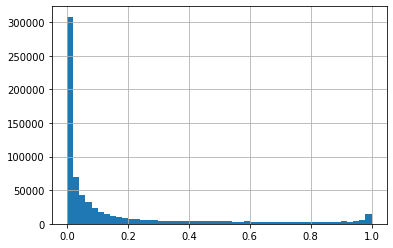

In [5]:
df['p'].hist(bins=50)

Compute performance metrics across all cross-validation folds:

In [6]:
y_test = df['GT'].values
y_prob = df['p'].values
y_pred = (y_prob > 0.5).astype(int)

{
    'Acc': np.round(accuracy_score(y_test, y_pred), 4),
    'BAC': np.round(balanced_accuracy_score(y_test, y_pred), 4),
    'Precision': np.round(precision_score(y_test, y_pred), 4),
    'Recall': np.round(recall_score(y_test, y_pred), 4),
    'PR-AUC': np.round(average_precision_score(y_test, y_prob), 4),
    'AUC': np.round(roc_auc_score(y_test, y_prob), 4),
}

{'Acc': 0.879,
 'BAC': 0.8895,
 'Precision': 0.0971,
 'Recall': 0.9003,
 'PR-AUC': 0.4331,
 'AUC': 0.9512}

Plot confusion matrix, with probability threshold for link prediction = 0.5:

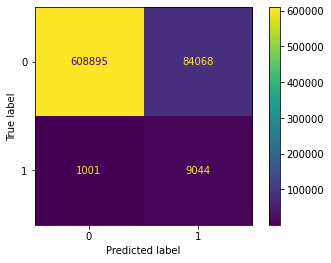

In [7]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Plot confusion matrix, with probability threshold for link prediction = 0.9:

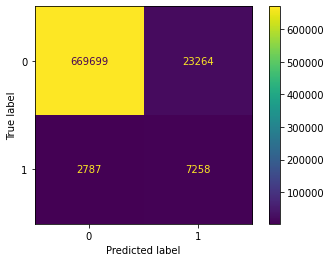

In [8]:
cm = confusion_matrix(y_test, (y_prob > 0.9).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Split dataframe into known (`df_o`) and unknown (`df_n`) links:

In [9]:
df_o = df[df['GT'] == 1].copy()
df_o

,Gen,Phn,p,GT
0,SLC9A1,D1071,0.983144,1
1,MAGI3,D1071,0.874537,1
2,S100A14,D1071,0.728153,1
3,C1orf35,D1071,0.831546,1
4,SUPT7L,D1071,0.994575,1
...,...,...,...,...
564411,PPFIA4,D1094,0.021077,1
564412,NCBP1,D1094,0.011201,1
564413,HAUS4P1,D1094,0.946368,1
564414,TSTD2,D1094,0.946368,1


For unknown links also compute the hits at both thresholds (0.5 and 0.9):

In [10]:
df_n = df[df['GT'] == 0].copy()
df_n['h.5'] = (df_n['p'] > 0.5).astype(int)
df_n['h.9'] = (df_n['p'] > 0.9).astype(int)
df_n

,Gen,Phn,p,GT,h.5,h.9
2009,HIPK1,D1071,0.868193,0,1,0
2010,BCAS2,D1071,0.992022,0,1,1
2011,SSR1,D1071,0.984533,0,1,1
2012,HLA-A,D1071,0.999580,0,1,1
2013,TRIM26,D1071,0.998707,0,1,1
...,...,...,...,...,...,...
703003,DDX11,D1222,0.002606,0,0,0
703004,ITPK1,D1222,0.002593,0,0,0
703005,MORF4,D1222,0.001918,0,0,0
703006,NINJ1,D1222,0.002593,0,0,0


Count the number of known links per phenotype:

In [11]:
df_o['Phn'].value_counts()

D1071    1105
D1251    1022
D1249    1003
D1075     752
D1536     494
         ... 
D1074       3
D1304       3
D1154       1
D1095       1
D1280       1
Name: Phn, Length: 72, dtype: int64

Count the number of predicted unknown links per phenotype:

In [12]:
df_n.groupby('Phn')[['h.5', 'h.9']].agg('sum').reset_index()

,Phn,h.5,h.9
0,C1007,338,15
1,C1010,604,205
2,C1052,418,94
3,C1067,445,203
4,C1068,444,184
...,...,...,...
67,L2003,207,22
68,L2004,329,113
69,L2005,339,113
70,L2006,319,116


In [13]:
counts = df_n.groupby('Phn')[['h.5', 'h.9']].agg('sum')
counts = counts.merge(df_o['Phn'].value_counts().to_frame(), left_index=True, right_index=True)
counts = counts.rename(columns={'Phn': '# of known edges'})
counts = counts[['# of known edges', 'h.5', 'h.9']]
counts = counts.sort_values('# of known edges', ascending=False)

print(counts.to_string())

        # of known edges   h.5   h.9
D1071               1105  8520  3570
D1251               1022  5934  1501
D1249               1003  5177  1389
D1075                752  1942   779
D1536                494  6317  1451
D1250                482  1454   628
D1416                396  1441   559
D1245                372  2351   852
D1153                369  1385   526
ModDRm               334  7407  2061
HumAge               307  6481  1223
D1524                295  1359   497
HumCel               279  6892  1558
D1155                263  1267   467
D1284                259  1248   416
D1526                221  5082   917
D1269                157  1267   418
C1010                153   604   205
C1068                115   444   184
D1523                111  1046   234
C1069                110   415   176
D1085                 87   367   147
D1112                 79   384   158
C1067                 68   445   203
D1182                 66   605   265
D1183                 63   586   252
D